In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


# 1. Import Libraries 

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore","use_inf_as_na ")

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.metrics import mean_squared_log_error, r2_score


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 2. Import Dataset 

In [3]:
train_path = "/kaggle/input/playground-series-s4e4/train.csv"
test_path = "/kaggle/input/playground-series-s4e4/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.shape, test_df.shape

((90615, 10), (60411, 9))

# 3. EDA

## Null Values

In [4]:
# null values in train set
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# null values in test set
test_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64

## Data Description

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [7]:
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [8]:
train_df.head(10)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
5,5,F,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10
6,6,M,0.415,0.325,0.110,0.3315,0.1655,0.0715,0.1300,9
7,7,F,0.610,0.490,0.150,1.1165,0.4955,0.2945,0.2950,9
8,8,I,0.205,0.150,0.040,0.0460,0.0145,0.0105,0.0100,4
9,9,I,0.565,0.425,0.125,0.6510,0.3795,0.1420,0.1800,8


## Dependent Variable: Rings

<Axes: xlabel='Rings', ylabel='Count'>

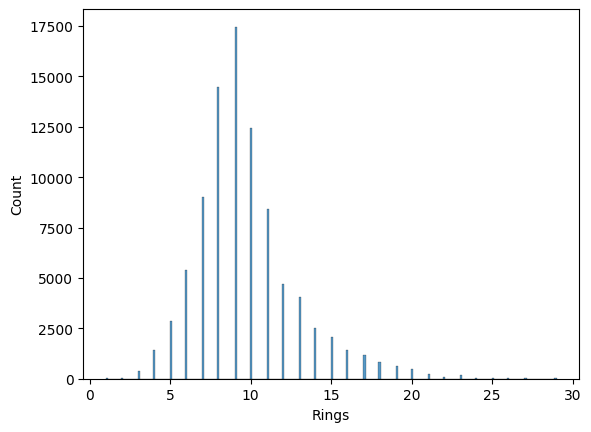

In [9]:
sns.histplot(train_df["Rings"])

In [10]:
train_df["Rings"].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

## Independent Variables

In [11]:
train_df["Sex"].value_counts(1)

Sex
I    0.365204
M    0.342405
F    0.292391
Name: proportion, dtype: float64

In [12]:
numeric_feature = [feature for feature in train_df if train_df[feature].dtype!= "O" and feature not in ["id", "Rings"]]
numeric_feature

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight']

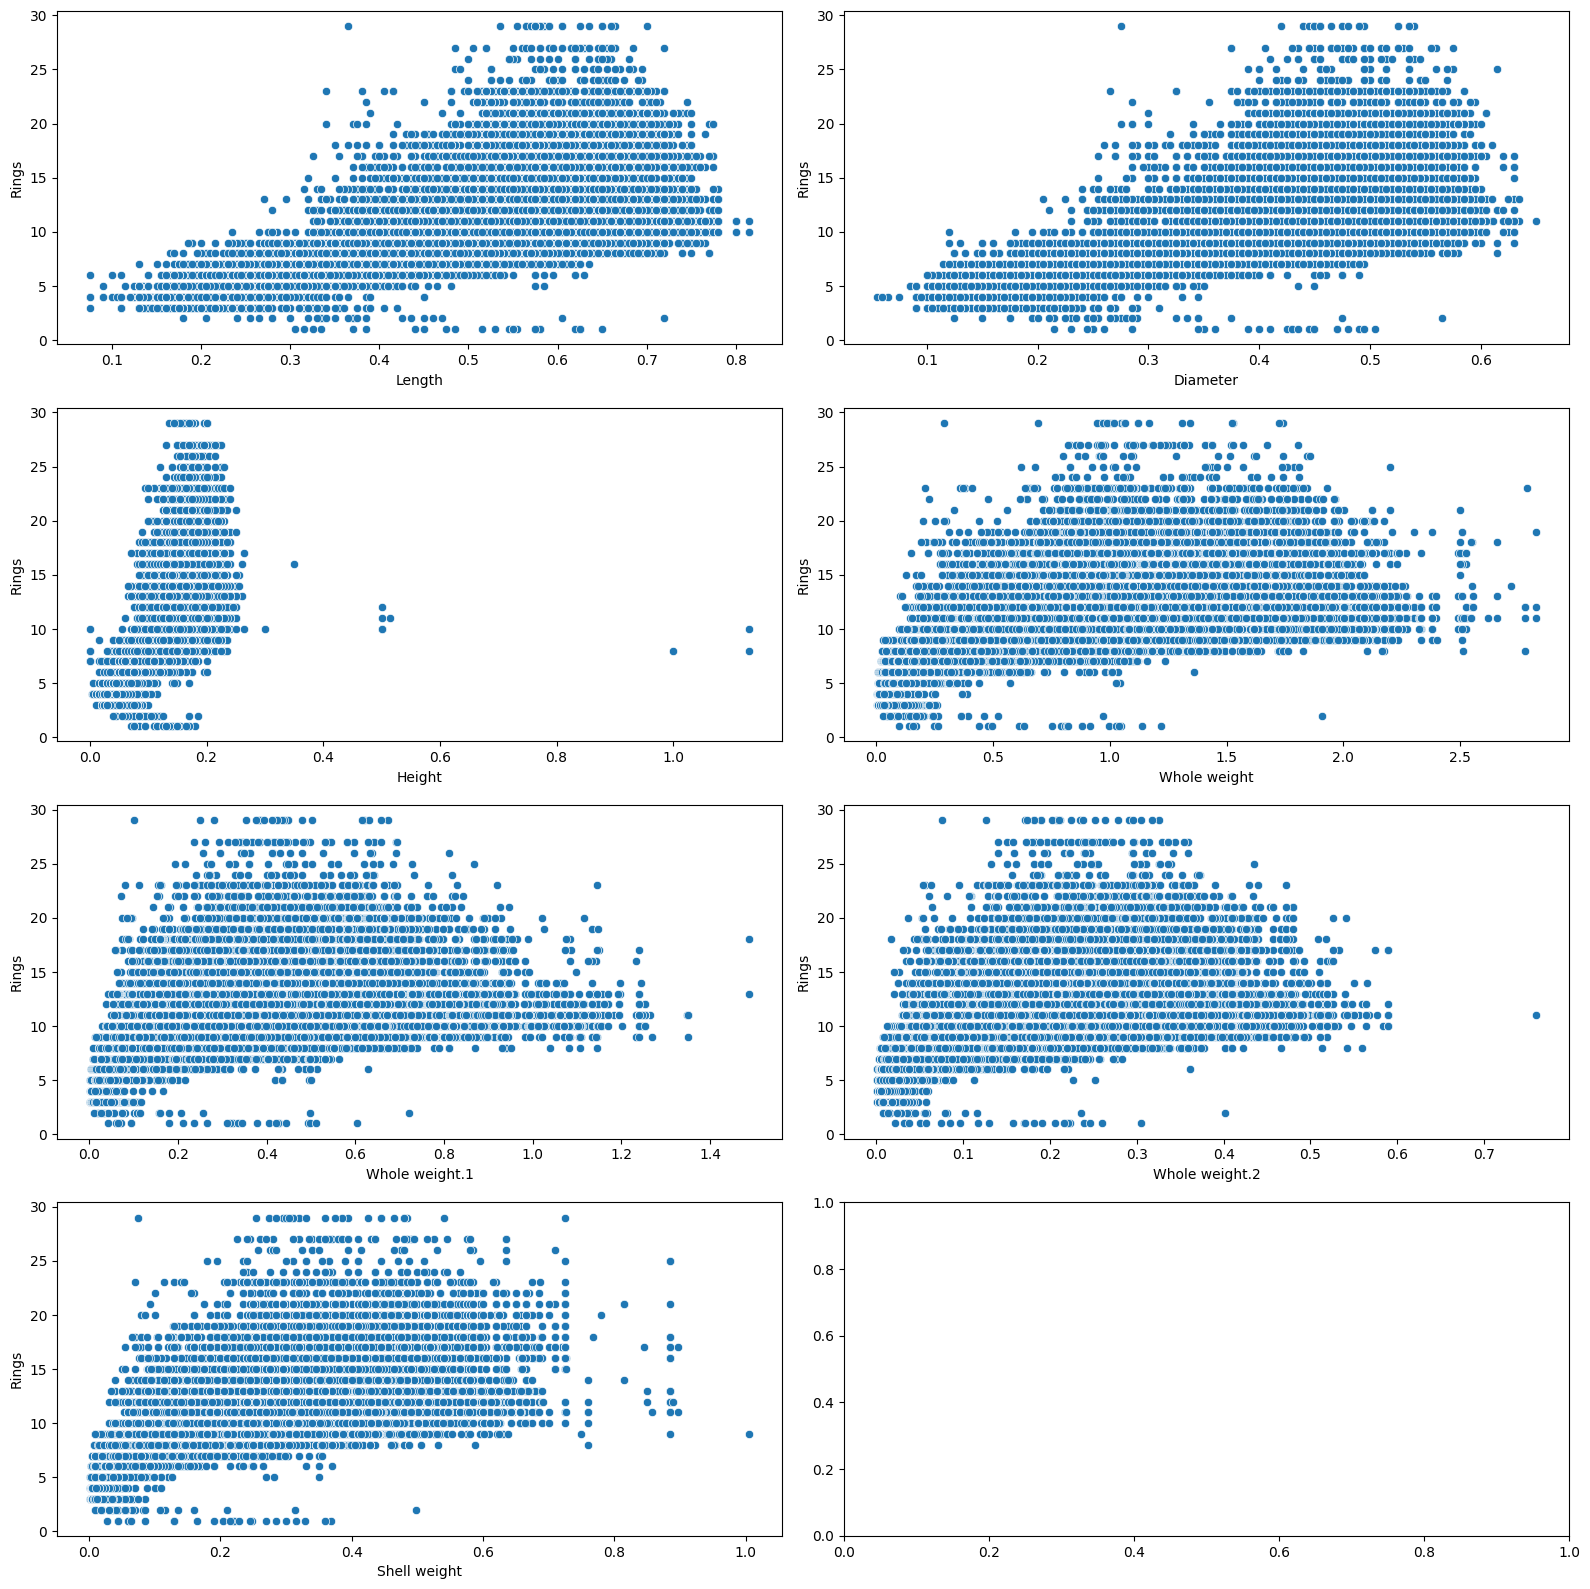

In [13]:
fig, axs = plt.subplots(4,2, figsize=(16,16))
for index, feature in enumerate(numeric_feature):
    sns.scatterplot(data=train_df, x=feature, y="Rings", ax= axs[index//2, index%2])
    
plt.tight_layout()
fig.show()

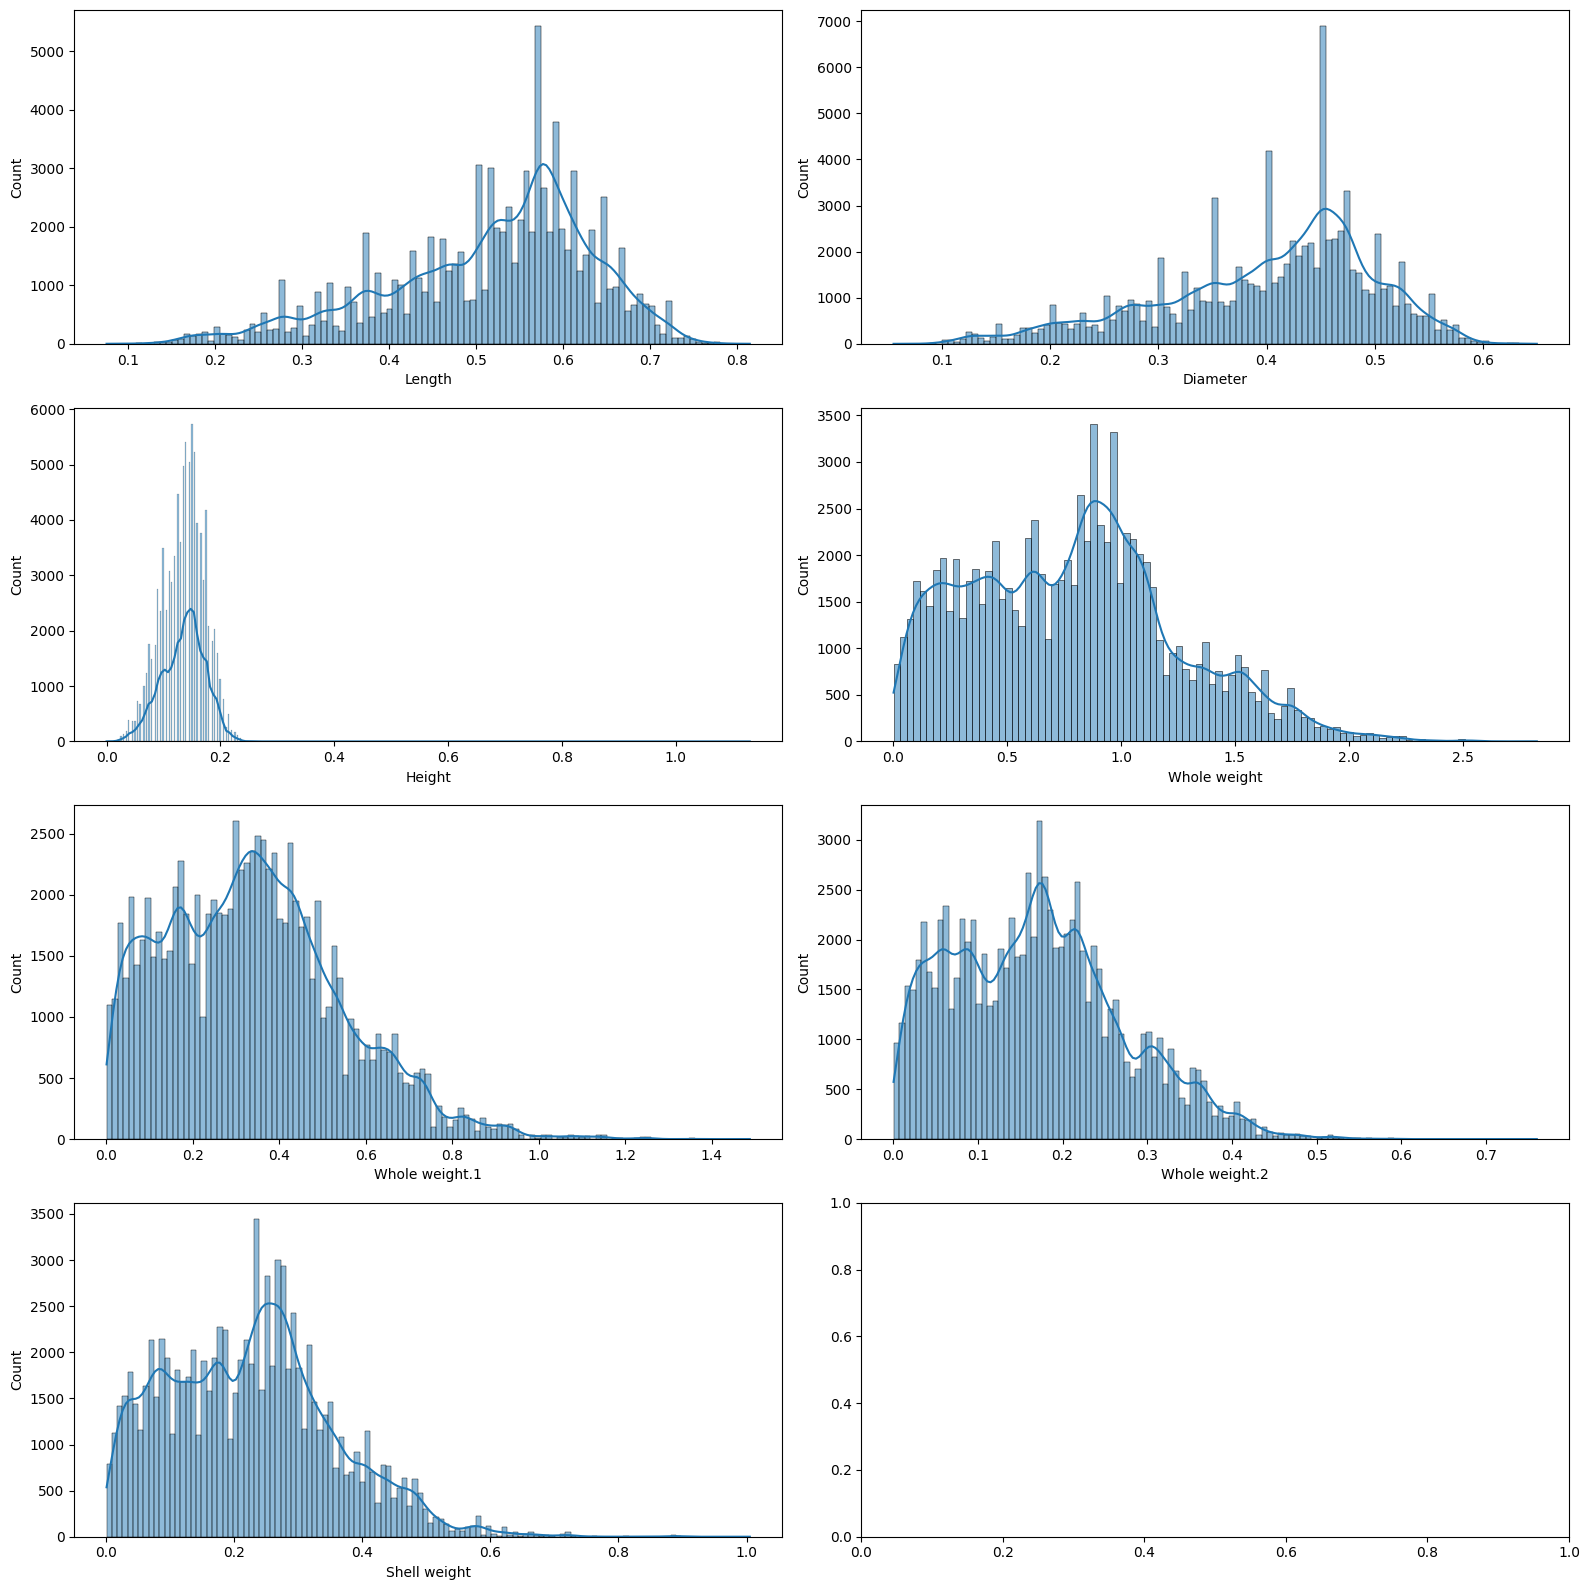

In [14]:
fig, axs = plt.subplots(4,2, figsize=(16,16))
for index, feature in enumerate(numeric_feature):
    sns.histplot(data=train_df, x=feature, ax= axs[index//2, index%2], kde=True)
    
plt.tight_layout()
fig.show()

In [15]:
def z_score(df, col):
    mean = df[col].mean()
    std = df[col].std()

    ll = (-3 * std) + mean
    ul = (3 * std) + mean

    mask = (df[col] < ll) | (df[col] > ul)
    temp = df[mask]

    if len(temp)>0:
        print(f"Method: Zscore Detection")
        print(f"Column: {col}")
        print(f"Lower bound: {round(ll, 2)}")
        print(f"Upper bound: {round(ul, 2)}")
        print(f"number of outliers in {col}: {len(temp)}")
        print(f"percentage of outliers: {round(len(temp) / len(df) * 100, 2)} %")
        print("---------------------------------------------\n")

    return [len(temp), [ll,ul], temp]


def iqr_limit(df, col):

    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    uw = q3 + 1.5 * iqr
    lw = q1 - 1.5 * iqr

    mask = (df[col] > uw) | (df[col] < lw)
    temp = df[mask]

    if len(temp)>0:
            print(f"Method: IQR Detection")
            print(f"Column: {col}")
            print(f"Lower Whiskers: {round(lw, 2)}")
            print(f"Upper Whiskers: {round(uw, 2)}")
            print(f"Number of Outliers in {col}: {len(temp)}")
            print(f"Percentage of Outliers in {col}: {round((len(temp) / len(df) * 100), 2)}%")
            print("---------------------------------------------\n")

    return [len(temp), [lw, uw], temp]
    
def find_outliers(df, col, method="z_score"):
    if method == "z_score":
        return z_score(df, col)
    else:
        return iqr_limit(df, col)
        
def detect_outliers(df):
    df = df.select_dtypes(exclude = "object")
    z_score_cols = []
    iqr_cols = []
    for col in df:
        skewness = df[col].skew()
        if -0.5 <= skewness <= 0.5:
            method = "z_score"
        else:
            method = "IQR"

        num_outlier = find_outliers(df, col, method)[0]
        if num_outlier:
            if method == "z_score":
                z_score_cols.append(col)
            else:
                iqr_cols.append(col)
    return z_score_cols,iqr_cols


In [16]:
detect_outliers(train_df[numeric_feature + ["Rings"]])

Method: IQR Detection
Column: Length
Lower Whiskers: 0.21
Upper Whiskers: 0.83
Number of Outliers in Length: 1460
Percentage of Outliers in Length: 1.61%
---------------------------------------------

Method: IQR Detection
Column: Diameter
Lower Whiskers: 0.16
Upper Whiskers: 0.66
Number of Outliers in Diameter: 1580
Percentage of Outliers in Diameter: 1.74%
---------------------------------------------

Method: Zscore Detection
Column: Height
Lower bound: 0.02
Upper bound: 0.25
number of outliers in Height: 92
percentage of outliers: 0.1 %
---------------------------------------------

Method: Zscore Detection
Column: Whole weight
Lower bound: -0.58
Upper bound: 2.16
number of outliers in Whole weight: 289
percentage of outliers: 0.32 %
---------------------------------------------

Method: IQR Detection
Column: Whole weight.1
Lower Whiskers: -0.25
Upper Whiskers: 0.89
Number of Outliers in Whole weight.1: 967
Percentage of Outliers in Whole weight.1: 1.07%
---------------------------

(['Height', 'Whole weight', 'Whole weight.2', 'Shell weight'],
 ['Length', 'Diameter', 'Whole weight.1', 'Rings'])

In [17]:
pt = PowerTransformer()

power_transformed_df = pd.DataFrame(data = pt.fit_transform(train_df[numeric_feature + ["Rings"]]),
                                   columns = pt.get_feature_names_out())

In [18]:
detect_outliers(power_transformed_df)

Method: Zscore Detection
Column: Length
Lower bound: -3.0
Upper bound: 3.0
number of outliers in Length: 33
percentage of outliers: 0.04 %
---------------------------------------------

Method: Zscore Detection
Column: Diameter
Lower bound: -3.0
Upper bound: 3.0
number of outliers in Diameter: 33
percentage of outliers: 0.04 %
---------------------------------------------

Method: Zscore Detection
Column: Height
Lower bound: -3.0
Upper bound: 3.0
number of outliers in Height: 77
percentage of outliers: 0.08 %
---------------------------------------------

Method: Zscore Detection
Column: Whole weight
Lower bound: -3.0
Upper bound: 3.0
number of outliers in Whole weight: 13
percentage of outliers: 0.01 %
---------------------------------------------

Method: Zscore Detection
Column: Whole weight.1
Lower bound: -3.0
Upper bound: 3.0
number of outliers in Whole weight.1: 47
percentage of outliers: 0.05 %
---------------------------------------------

Method: Zscore Detection
Column: Whole

(['Length',
  'Diameter',
  'Height',
  'Whole weight',
  'Whole weight.1',
  'Whole weight.2',
  'Shell weight',
  'Rings'],
 [])

In [19]:
numeric_feature

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight']

* volume: I have length, height and diameter. 

- See if volume has something to do with rings


In [20]:
train_df["Radius"] = train_df["Diameter"]/2
train_df["volume"] = np.pi * (train_df["Radius"] ** 2) * train_df["Height"]
train_df.head(6)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Radius,volume
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0.2150,0.021783
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0.2450,0.027343
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.0550,0.000238
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.2375,0.026581
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.2125,0.018442
5,5,F,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10,0.2400,0.030762


In [21]:
train_df[numeric_feature+["volume","Rings"]].corr()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,volume,Rings
Length,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.920473,0.623786
Diameter,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.932829,0.636832
Height,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.942925,0.665772
Whole weight,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.970500,0.617274
Whole weight.1,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.937783,0.515067
Whole weight.2,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.951433,0.588954
Shell weight,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.956929,0.694766
volume,0.920473,0.932829,0.942925,0.970500,0.937783,0.951433,0.956929,1.000000,0.626801
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,0.626801,1.000000


In [22]:
train_df[numeric_feature+["volume","Rings"]].corr()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,volume,Rings
Length,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.920473,0.623786
Diameter,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.932829,0.636832
Height,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.942925,0.665772
Whole weight,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.970500,0.617274
Whole weight.1,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.937783,0.515067
Whole weight.2,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.951433,0.588954
Shell weight,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.956929,0.694766
volume,0.920473,0.932829,0.942925,0.970500,0.937783,0.951433,0.956929,1.000000,0.626801
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,0.626801,1.000000


<Axes: xlabel='Sex', ylabel='Rings'>

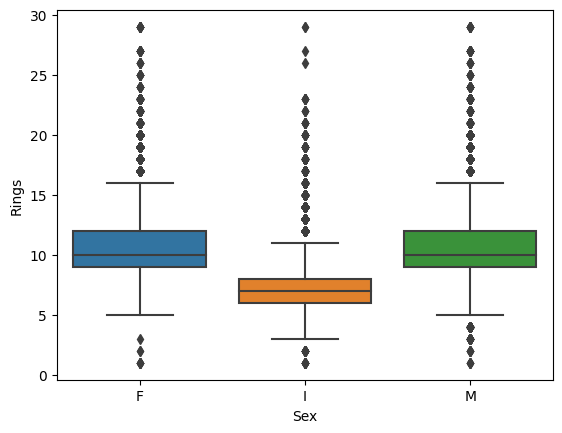

In [23]:
sns.boxplot(train_df, x="Sex", y="Rings")

# Preprocessing 

In [24]:
# reading a fresh copy

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# drop id 
train_df.drop(columns="id", inplace=True)
test_df.drop(columns="id", inplace=True)


# seperating features and label
X = train_df.drop(columns="Rings")
y = train_df["Rings"]

# splitting train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((72492, 8), (72492,), (18123, 8), (18123,))

In [25]:
# power transform

pt = PowerTransformer()

power_transformed_train = pd.DataFrame(data = pt.fit_transform(X_train[numeric_feature]),
                                   columns = pt.get_feature_names_out(),
                                   index=X_train.index)
power_transformed_train = pd.concat([X_train["Sex"],power_transformed_train],axis=1)

power_transformed_validate = pd.DataFrame(data = pt.transform(X_val[numeric_feature]),
                                   columns = pt.get_feature_names_out(),
                                   index=X_val.index)
power_transformed_validate = pd.concat([X_val["Sex"],power_transformed_validate],axis=1)

In [26]:
# encoding sex feature

ohe = OneHotEncoder(sparse_output=False,handle_unknown="ignore", drop="first")

ohe_train = pd.DataFrame(data = ohe.fit_transform(X_train["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = X_train.index)
ohe_train = pd.concat([ohe_train, X_train.drop(columns="Sex")], axis=1)


ohe_validate = pd.DataFrame(data = ohe.transform(X_val["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = X_val.index)
ohe_validate = pd.concat([ohe_validate, X_val.drop(columns="Sex")], axis=1)


In [27]:
# also encoding our power transformed data

ohe_pt_train = pd.DataFrame(data = ohe.fit_transform(power_transformed_train["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = power_transformed_train.index)
power_transformed_train = pd.concat([ohe_pt_train, power_transformed_train.drop(columns="Sex")], axis=1)


ohe_pt_validate = pd.DataFrame(data = ohe.transform(power_transformed_validate["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = power_transformed_validate.index)
power_transformed_validate = pd.concat([ohe_pt_validate, power_transformed_validate.drop(columns="Sex")], axis=1)


# Model Building

In [28]:
# model evaluation
def evaluation(method, x_train, x_test, y_train, y_test, 
               model=None, result_df=pd.DataFrame(), folds=5):
    """
    method: Tuning parameter for reference
    x_train: trianing dataset to train the model
    x-test: testing dataset to test the model
    y_trian: label values of trainig dataset
    y_test: label values of testing dataset to evluate
    result_df: Dataframe to store the result of each model
   """
    
    model = model

    if not any(result_df):
        result_df = pd.DataFrame({
    "method": [],
    "r2_train": [],
    "r2_test":[],
    "adj_r2_train": [],
    "adj_r2_test": [],
    "train_rmsle": [],
    "test_rmsle": []
    })
    n_r_train, n_c_train = x_train.shape
    n_r_test, n_c_test = x_test.shape

    # model fit
    model.fit(x_train, y_train)
    
    # predict
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    
    # r2 score
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # adjusted r2
    adj_r2_train = 1 - ((1-train_r2)*(n_r_train-1)/ (n_r_train-n_c_train-1))
    adj_r2_test = 1 - ((1-test_r2)*(n_r_test-1)/ (n_r_test-n_c_test-1))

    # rmsle
    train_rmsle = mean_squared_log_error(y_train, y_pred_train, squared=False)
    test_rmsle = mean_squared_log_error(y_test, y_pred_test, squared=False)

    # cv_rmsle
    cv = KFold(n_splits=folds, random_state=1, shuffle=True)
    cv_train_rmsle = -cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1).mean()
    cv_test_rmsle = -cross_val_score(model, x_test, y_test, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1).mean()

    
    
    temp_df = pd.DataFrame({
    "method": [method],
    "r2_train": [round(train_r2,4)],
    "r2_test":[round(test_r2,4)],
    "adj_r2_train": [round(adj_r2_train,4)],
    "adj_r2_test": [round(adj_r2_test,4)],
    "train_rmsle": [round(train_rmsle,4)],
    "test_rmsle": [round(test_rmsle,4)],
    "cv_train_rmsle": [round(train_rmsle,4)],
    "cv_test_rmsle": [round(test_rmsle,4)]

    })
    result_df = pd.concat([result_df, temp_df]).reset_index(drop=True)
    return result_df